# Setup

In [80]:
library(tidyverse)
library(caret)

library(ranger)
library(ropls)
library(e1071)

In [2]:
source("~/src/JupyterRReuse/VisualizationUtils.R")
# source("ggcorplot.R")

[1] "Loading module to 'visutil' and 'vu' (commit: a34b880a759d189e3a58beb742c2fa0e121bf991)"


In [6]:
pre_cols <- c("nr", "RI")
stone_cols <- c("Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe")
post_cols <- c("Type")
all_cols <- c(pre_cols, stone_cols, post_cols)

wide_stones_df <- read_csv("glass.data", col_names = all_cols)
wide_stones_df$Type <- as.factor(wide_stones_df$Type)
head(wide_stones_df)
dim(wide_stones_df)
glimpse(wide_stones_df)

Parsed with column specification:
cols(
  nr = col_integer(),
  RI = col_double(),
  Na = col_double(),
  Mg = col_double(),
  Al = col_double(),
  Si = col_double(),
  K = col_double(),
  Ca = col_double(),
  Ba = col_double(),
  Fe = col_double(),
  Type = col_integer()
)


nr,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


[1] 214  11

Observations: 214
Variables: 11
$ nr   <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,...
$ RI   <dbl> 1.52101, 1.51761, 1.51618, 1.51766, 1.51742, 1.51596, 1.51743,...
$ Na   <dbl> 13.64, 13.89, 13.53, 13.21, 13.27, 12.79, 13.30, 13.15, 14.04,...
$ Mg   <dbl> 4.49, 3.60, 3.55, 3.69, 3.62, 3.61, 3.60, 3.61, 3.58, 3.60, 3....
$ Al   <dbl> 1.10, 1.36, 1.54, 1.29, 1.24, 1.62, 1.14, 1.05, 1.37, 1.36, 1....
$ Si   <dbl> 71.78, 72.73, 72.99, 72.61, 73.08, 72.97, 73.09, 73.24, 72.08,...
$ K    <dbl> 0.06, 0.48, 0.39, 0.57, 0.55, 0.64, 0.58, 0.57, 0.56, 0.57, 0....
$ Ca   <dbl> 8.75, 7.83, 7.78, 8.22, 8.07, 8.07, 8.17, 8.24, 8.30, 8.40, 8....
$ Ba   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ Fe   <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 0.26, 0.00, 0.00, 0.00, 0.11, 0....
$ Type <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...


In [7]:
long_stones_df <- wide_stones_df %>% select(stone_cols) %>% gather()
head(long_stones_df, 5)

key,value
Na,13.64
Na,13.89
Na,13.53
Na,13.21
Na,13.27


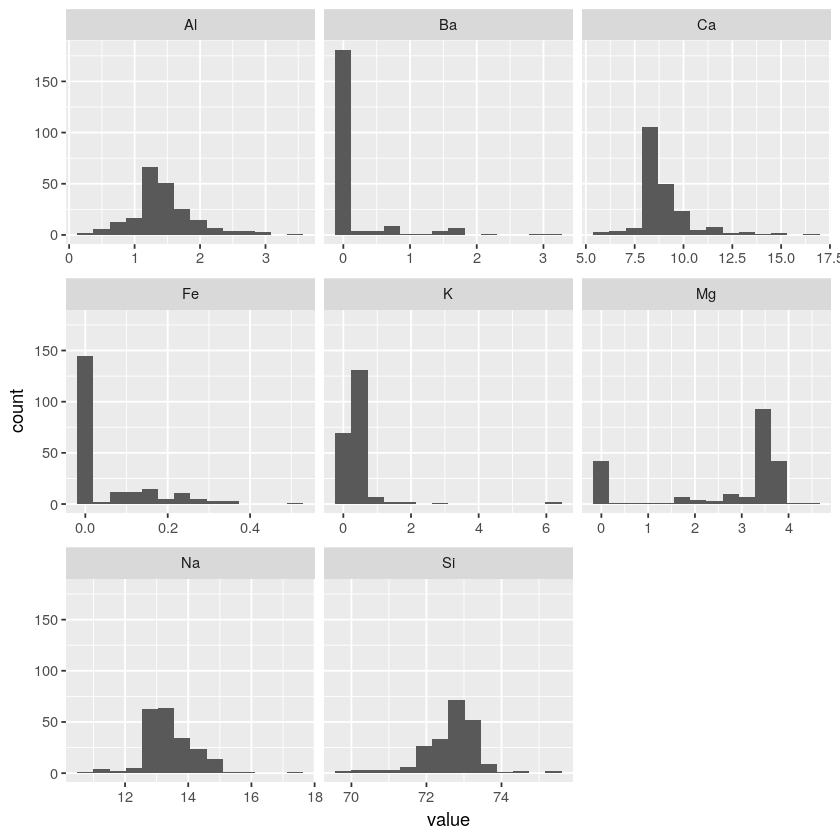

In [8]:
ggplot(long_stones_df, aes(value)) + geom_histogram(bins=14) + facet_wrap(~key, scales='free_x')

# Variable screening

Check:

* How much correlation do we have?
* What is relative importances of variables?

### Correlation

Some relatively high positive and negative correlations.

In [9]:
cor_mat <- cor(wide_stones_df %>% select(stone_cols))
cor_mat

,Na,Mg,Al,Si,K,Ca,Ba,Fe
Na,1.00000000,-0.273731961,0.15679367,-0.06980881,-0.266086504,-0.2754425,0.32660288,-0.241346411
Mg,-0.27373196,1.000000000,-0.48179851,-0.16592672,0.005395667,-0.4437500,-0.49226212,0.083059529
Al,0.15679367,-0.481798509,1.00000000,-0.00552372,0.325958446,-0.2595920,0.47940390,-0.074402151
Si,-0.06980881,-0.165926723,-0.00552372,1.00000000,-0.193330854,-0.2087322,-0.10215131,-0.094200731
K,-0.26608650,0.005395667,0.32595845,-0.19333085,1.000000000,-0.3178362,-0.04261806,-0.007719049
Ca,-0.27544249,-0.443750026,-0.25959201,-0.20873215,-0.317836155,1.0000000,-0.11284097,0.124968219
Ba,0.32660288,-0.492262118,0.47940390,-0.10215131,-0.042618059,-0.1128410,1.00000000,-0.058691755
Fe,-0.24134641,0.083059529,-0.07440215,-0.09420073,-0.007719049,0.1249682,-0.05869176,1.000000000


In [10]:
head(cor_mat)

,Na,Mg,Al,Si,K,Ca,Ba,Fe
Na,1.00000000,-0.273731961,0.15679367,-0.06980881,-0.266086504,-0.2754425,0.32660288,-0.241346411
Mg,-0.27373196,1.000000000,-0.48179851,-0.16592672,0.005395667,-0.4437500,-0.49226212,0.083059529
Al,0.15679367,-0.481798509,1.00000000,-0.00552372,0.325958446,-0.2595920,0.47940390,-0.074402151
Si,-0.06980881,-0.165926723,-0.00552372,1.00000000,-0.193330854,-0.2087322,-0.10215131,-0.094200731
K,-0.26608650,0.005395667,0.32595845,-0.19333085,1.000000000,-0.3178362,-0.04261806,-0.007719049
Ca,-0.27544249,-0.443750026,-0.25959201,-0.20873215,-0.317836155,1.0000000,-0.11284097,0.124968219


### Correlation matrix

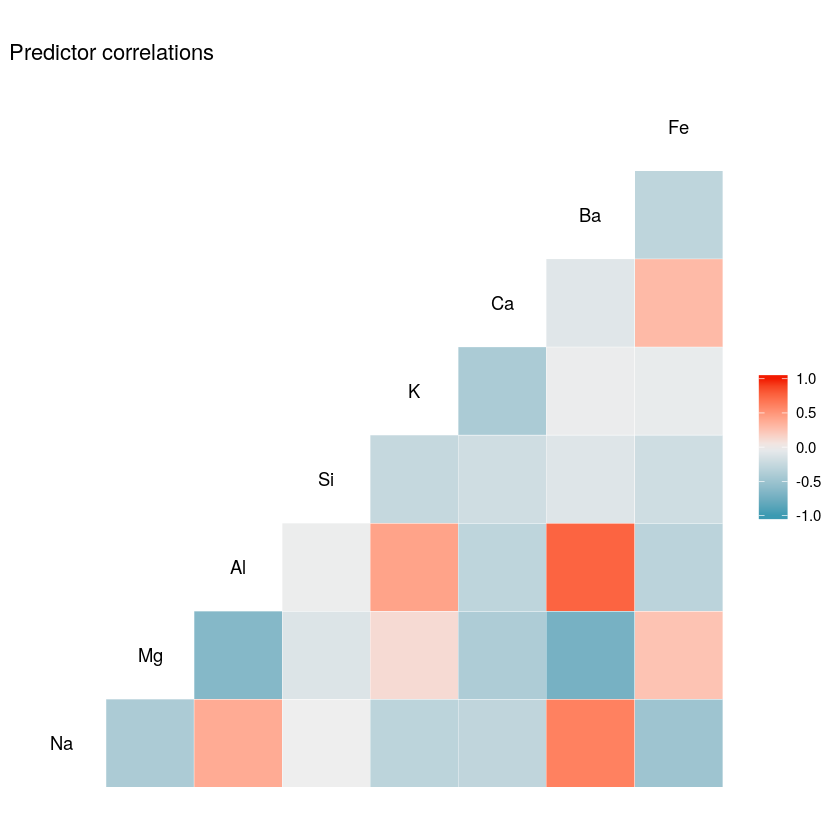

In [11]:
GGally::ggcorr(cor_mat) + ggtitle("Predictor correlations")

### Correlation distribution

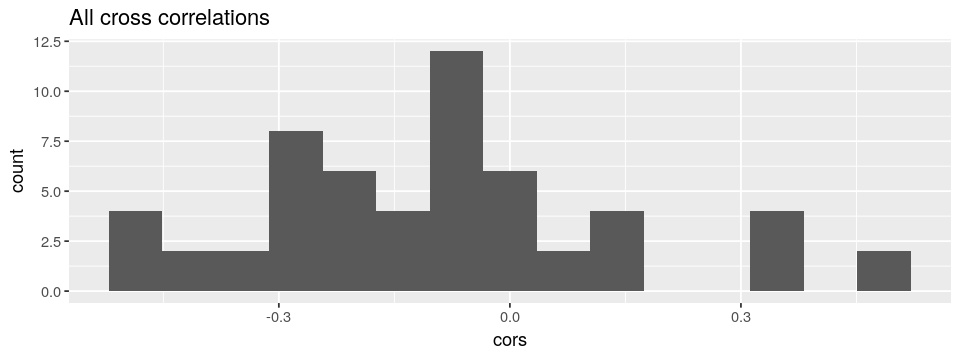

In [12]:
cors_dist_df <- data.frame(cors=as.vector(cor_mat)) %>% filter(cors != 1)
vu$pltsize(8, 3)
ggplot(cors_dist_df, aes(cors)) + geom_histogram(bins=15) + ggtitle("All cross correlations")

### Zero count

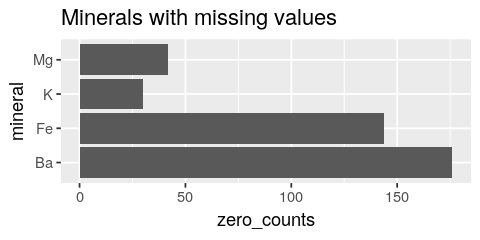

In [74]:
zero_counts <- colSums(as.matrix(wide_stones_df[, stone_cols] == 0))
zero_df <- as.data.frame(zero_counts) %>% add_column(mineral=names(zero_counts)) %>% filter(zero_counts != 0)

vu$pltsize(4, 2)
ggplot(
    zero_df,
    aes(mineral, zero_counts)
) + geom_col() + coord_flip() + ggtitle("Minerals with missing values")

### Pairwise scatter

In [25]:
pairwise_comp <- function(df, sample1, sample2) {
    
    ggplot(df, aes_string(x=df[[sample1]], y=df[[sample2]])) + 
        geom_point() +
        ggtitle(paste(sample1, "vs", sample2)) +
        geom_smooth(method="lm", formula=y~x) +
        xlab(sample1) +
        ylab(sample2)
}

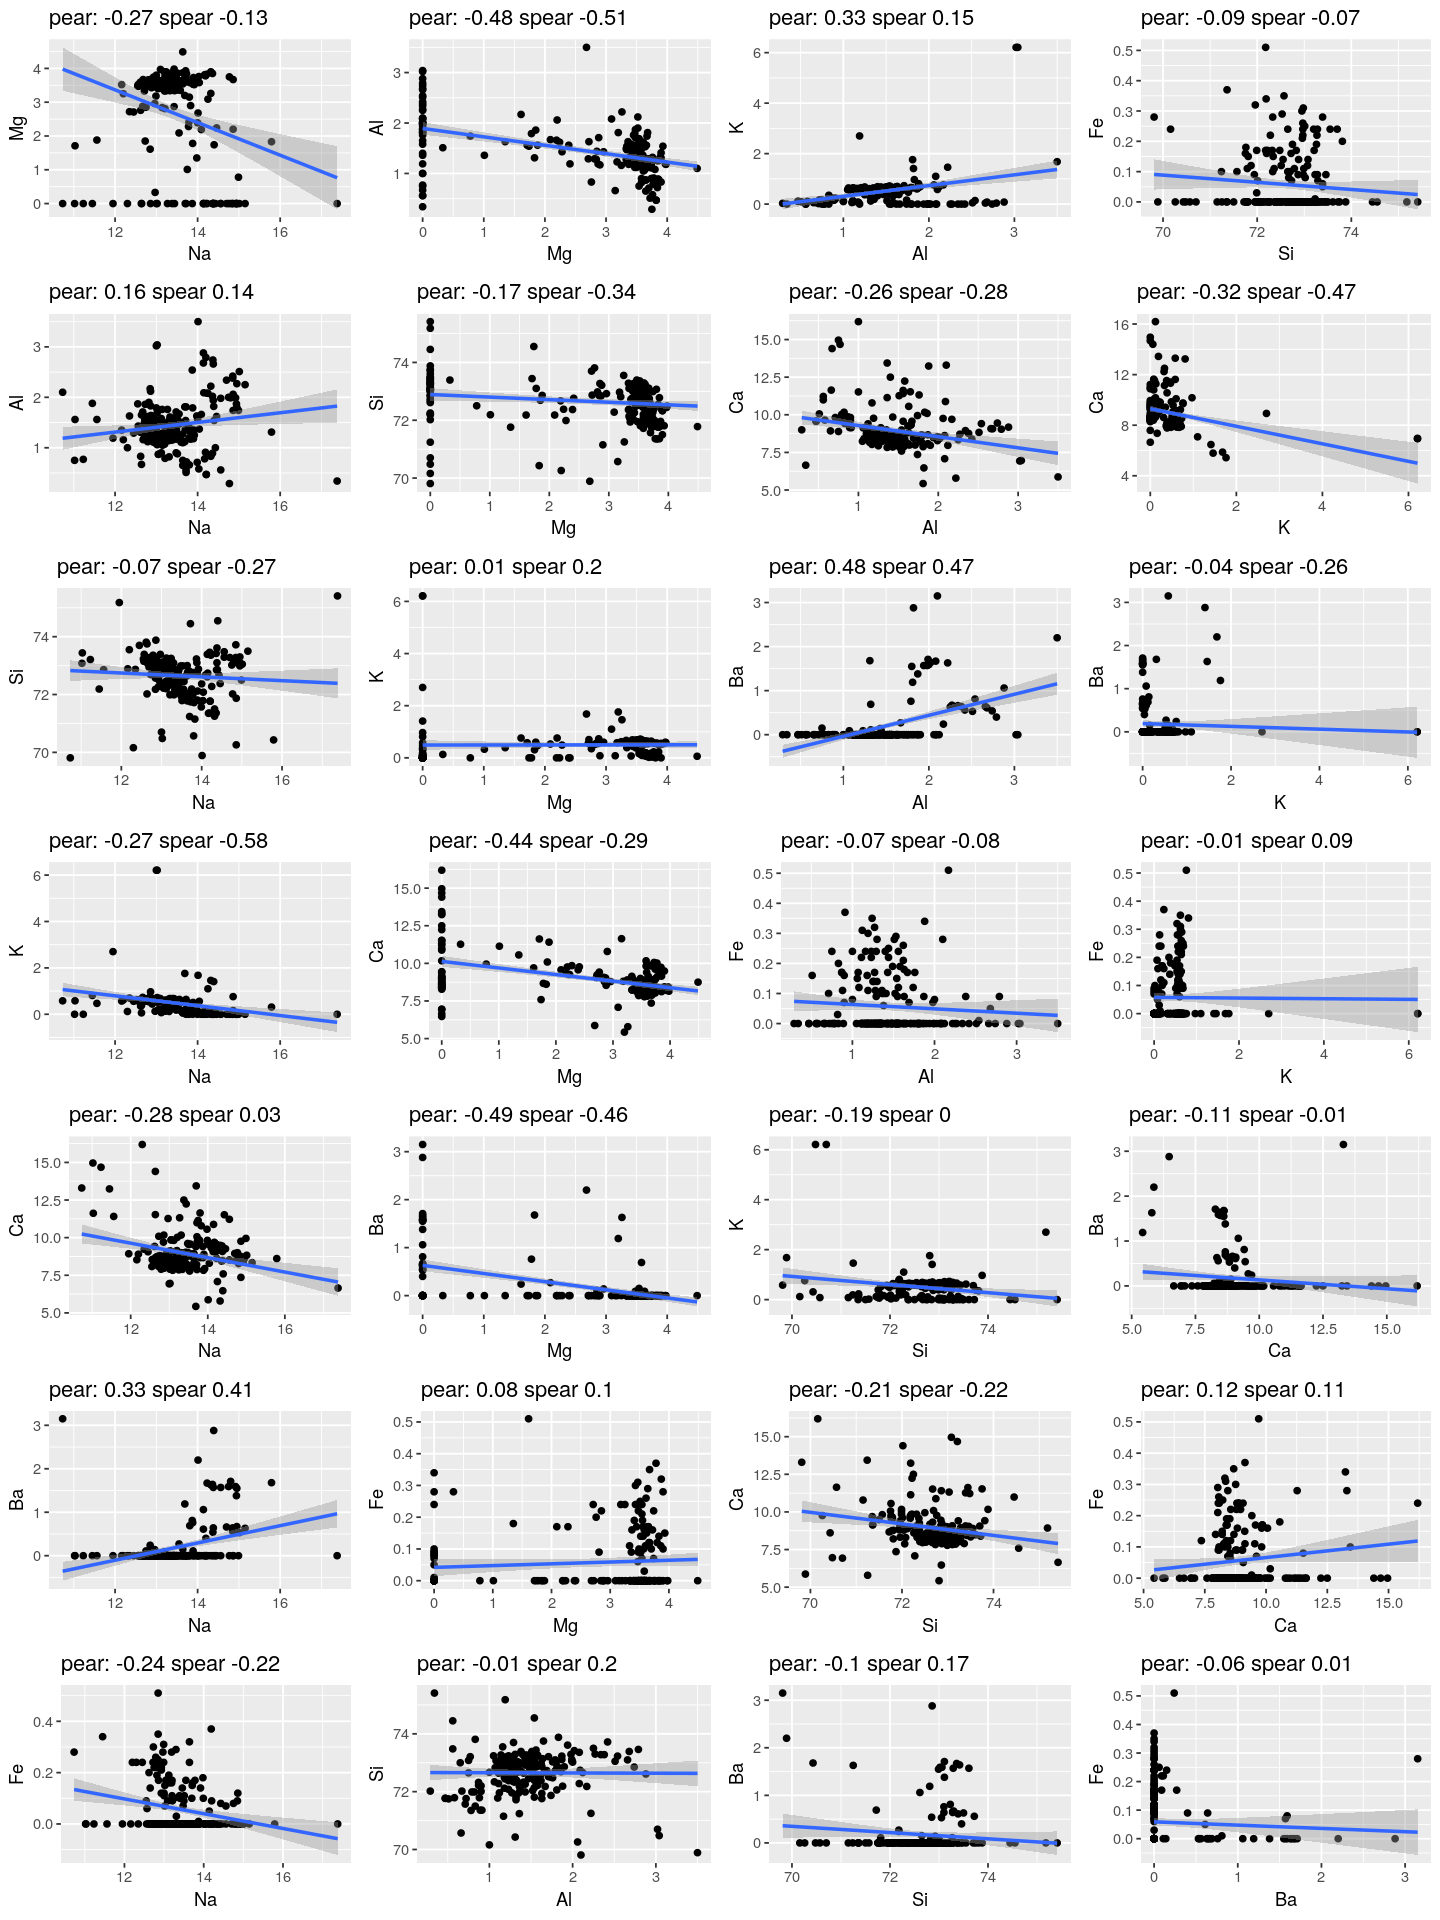

In [51]:
all_comps <- list()
combs <- combn(unique(long_stones_df$key), 2)
for (comb_i in seq_len(ncol(combs))) {
    comb <- combs[, comb_i]
    pear_cor <- cor(wide_stones_df[, comb[1]], wide_stones_df[, comb[2]], method = "pearson")
    spear_cor <- cor(wide_stones_df[, comb[1]], wide_stones_df[, comb[2]], method = "spearman")
    my_title <- paste("pear:", round(pear_cor, 2), "spear", round(spear_cor, 2))
    all_comps[[comb_i]] <- pairwise_comp(wide_stones_df, comb[1], comb[2]) + ggtitle(my_title)
}

vu$pltsize(12, 16)
vu$multiplot(plotlist=all_comps, cols=4)

# PCA analysis

In [111]:
library("FactoMineR")
library("factoextra")

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


In [118]:
res.pca <- PCA(wide_stones_df[, stone_cols])
var <- get_pca_var(res.pca)
var

Principal Component Analysis Results for variables
  Name       Description                                    
1 "$coord"   "Coordinates for the variables"                
2 "$cor"     "Correlations between variables and dimensions"
3 "$cos2"    "Cos2 for the variables"                       
4 "$contrib" "contributions of the variables"               

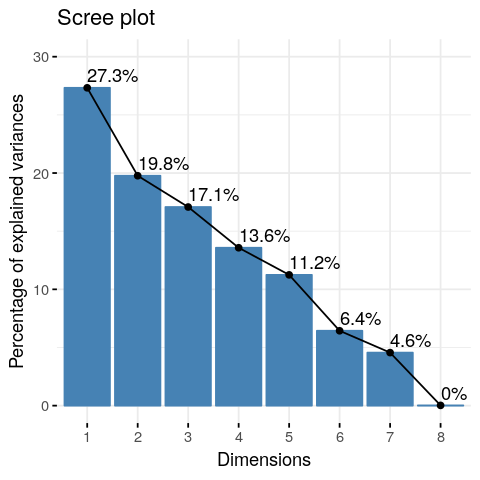

In [114]:
vu$pltsize(4, 4)
fviz_eig(res.pca, addlabels=TRUE, ylim=c(0, 30))

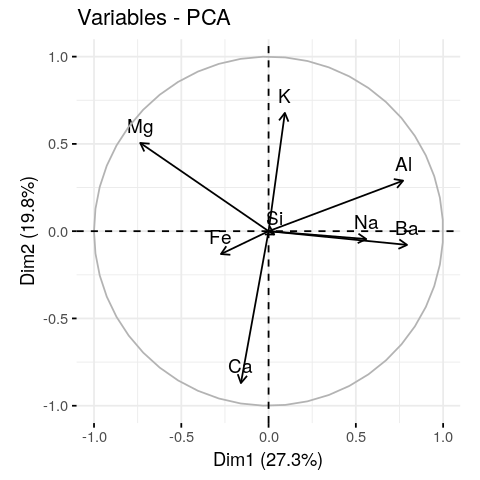

In [116]:
fviz_pca_var(res.pca, col.var="black")

In [120]:
library("corrplot")

corrplot 0.84 loaded


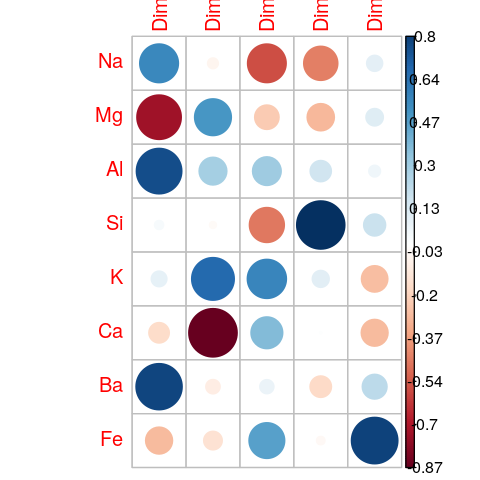

In [125]:
corrplot(var$cor, is.corr=F)

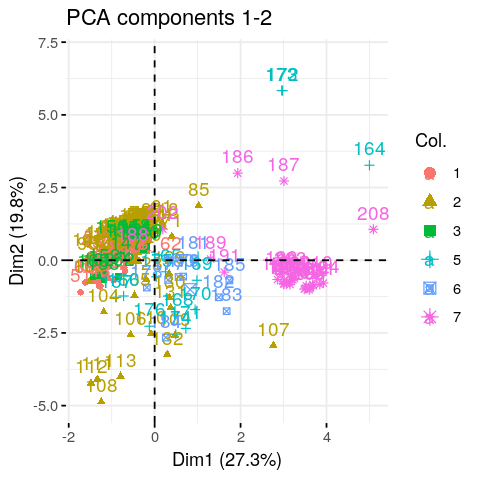

In [136]:
fviz_pca_ind(
    res.pca, 
    col.ind=wide_stones_df$Type, 
    addEllipses=F) + ylim(-5, 7) + ggtitle("PCA components 1-2")

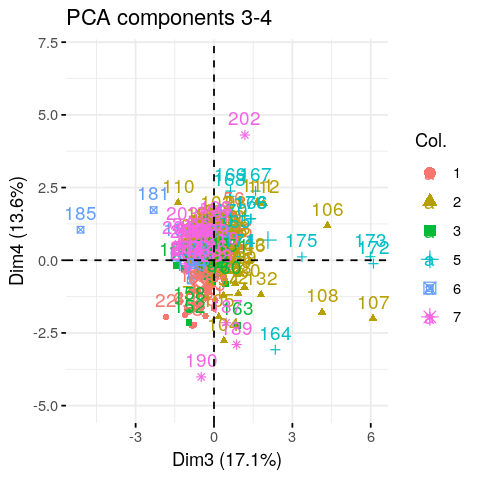

In [135]:
fviz_pca_ind(
    res.pca, 
    col.ind=wide_stones_df$Type, 
    addEllipses=F, 
    axes = c(3,4)) + ylim(-5, 7) + ggtitle("PCA components 3-4")

# Training

Start with using all variables as continuous. Try a general regression. Also try a logistic model.

In [75]:
head(wide_stones_df)

nr,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


In [102]:
control <- caret::trainControl(
    method="repeatedcv",
    number=10,
    repeats=3
)

models <- list()
# methods <- c("lm", "")

print("Training random forest for parameter importance estimate")
rf_model <- caret::train(
    Type~.,
    data=wide_stones_df %>% dplyr::select(-nr),
    method="ranger",
    preProcess="scale",
    importance="permutation",
    trControl=control
)


[1] "Training random forest for parameter importance estimate"


In [105]:
print(rf_model)

Random Forest 

214 samples
  9 predictors
  6 classes: '1', '2', '3', '5', '6', '7' 

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 192, 193, 193, 194, 191, 192, ... 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa    
  2     gini        0.8166187  0.7448718
  2     extratrees  0.7853686  0.6988912
  5     gini        0.7888779  0.7087735
  5     extratrees  0.7936749  0.7133748
  9     gini        0.7620020  0.6721401
  9     extratrees  0.7902108  0.7095950

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 2, splitrule = gini
 and min.node.size = 1.


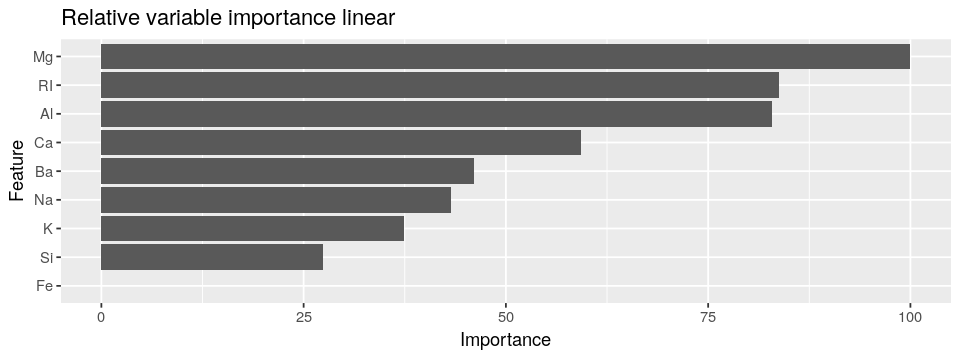

In [106]:

for (model_name in "linear") {
    model <- models[[model_name]]
#     print(model)
    importance <- caret::varImp(rf_model, threshold=10)
    # print(importance)
    vu$pltsize(8, 3)
    plt <- ggplot(importance) + ggtitle(paste("Relative variable importance", model_name))
    print(plt)
}



# Recursive feature selection

In [107]:
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
results <- rfe(
    Type~.,
    data=wide_stones_df %>% dplyr::select(-nr),
    sizes=1:nrow(wide_stones_df),
    rfeControl=control
)

In [108]:
head(results$variables)

1,2,3,5,6,7,Overall,var,Variables,Resample
27.32556,25.12481,11.091925,20.434784,12.2867233,16.369996,18.77230,Mg,9,Fold01
31.82132,21.42105,10.307185,6.151115,6.9137456,6.470139,13.84743,RI,9,Fold01
22.63994,16.99563,6.253305,16.650914,-2.4806645,14.129164,12.36472,Al,9,Fold01
14.72231,25.18074,6.978986,16.629048,0.3881792,7.759863,11.94319,Ca,9,Fold01
15.60397,11.85824,5.258924,8.627678,15.6282369,6.565295,10.59039,K,9,Fold01
13.46868,9.04143,3.158812,10.249803,11.2467804,13.256649,10.07036,Na,9,Fold01


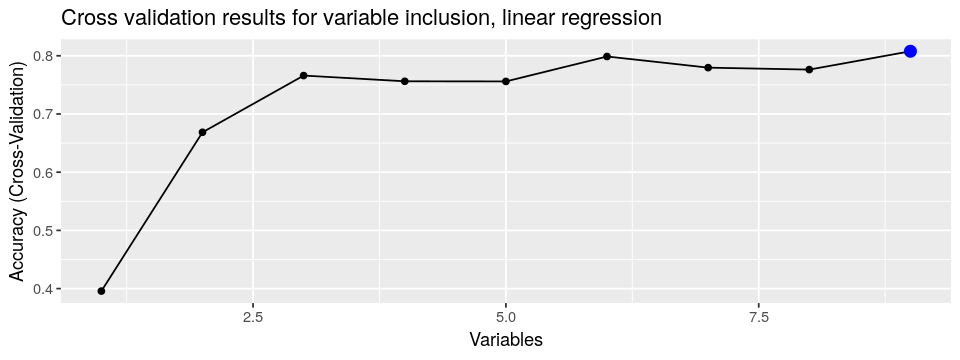

In [109]:
pred_subset <- predictors(results)
ggplot(results) + ggtitle("Cross validation results for variable inclusion, linear regression")

# Training models

In [153]:
my_folds <- createFolds(wide_stones_df$Type, k=5)

control_cv <- caret::trainControl(
    classProbs=T,
    savePredictions=T,
    summaryFunction=twoClassSummary,
    index=my_folds
)

pre_proc <- c("center", "scale")

In [156]:
trained_models <- list()
target_models <- c("pls", "ranger", "glmnet", "svmLinear", "svmRadial", "knn")

for (model in target_models) {
    
    print(paste("Training model:", model))

    trained_models[[model]] <- caret::train(
        Type~., 
        data=wide_stones_df %>% dplyr::select(-nr), 
        method=model, 
        preProcess="scale", 
        trControl=control,
        allowParallel=TRUE
    )
}


[1] "Training model: pls"


Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”

[1] "Training model: ranger"
[1] "Training model: glmnet"
[1] "Training model: svmLinear"
[1] "Training model: svmRadial"
[1] "Training model: knn"


# Visualize parameter optimizations

[1] "pls"
[1] "ranger"
[1] "glmnet"
[1] "svmLinear"


svmLinear didn't have tuning


[1] "svmRadial"
[1] "knn"


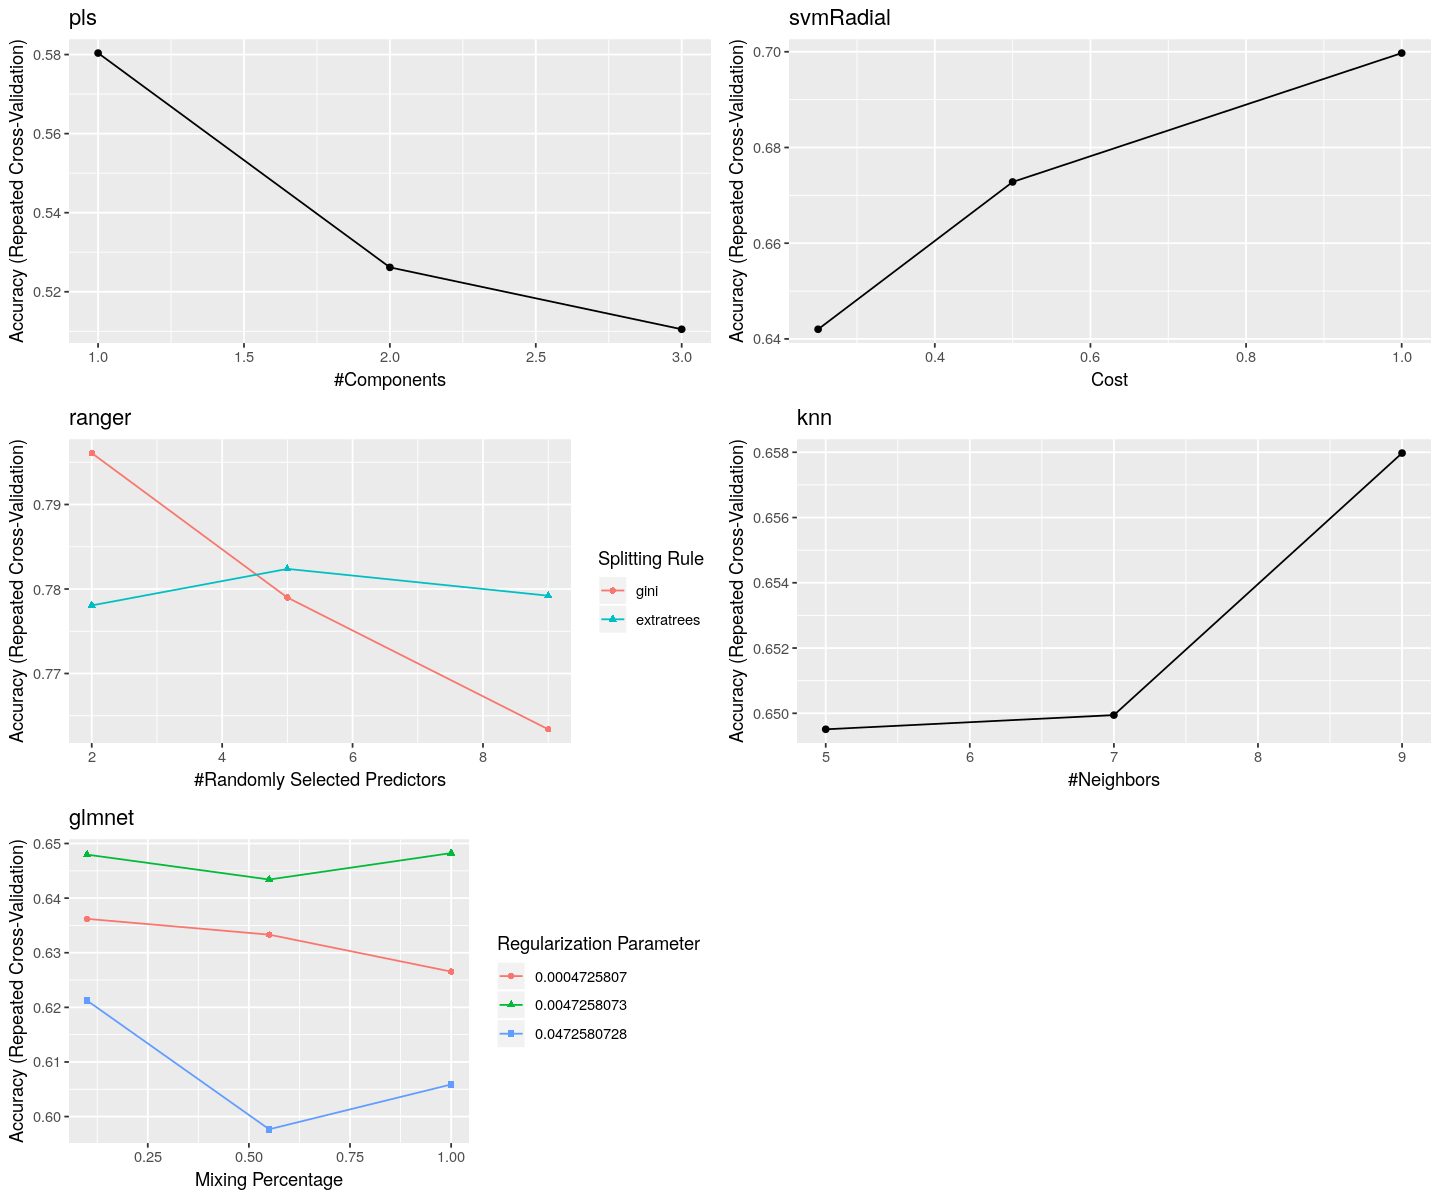

In [176]:
pltlist <- list()
for (mod_name in names(trained_models)) {
    trained_model <- trained_models[[mod_name]]
    print(mod_name)
    plt <- tryCatch({
        ggplot(trained_model) + ggtitle(mod_name)
    }, error=function(cond) {message(mod_name, " didn't have tuning")})
    pltlist[[mod_name]] <- plt
}

vu$pltsize(12, 10)
vu$multiplot(plotlist=pltlist, cols=2)

# Model performances

In [178]:
for (model_name in names(trained_models)) {
    message(rep("---", 10), model_name, rep("---", 10))
    print(trained_models[[model_name]])
}

------------------------------pls------------------------------


Partial Least Squares 

214 samples
  9 predictors
  6 classes: '1', '2', '3', '5', '6', '7' 

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 192, 193, 193, 194, 191, 193, ... 
Resampling results across tuning parameters:

  ncomp  Accuracy   Kappa    
  1      0.5803749  0.3968658
  2      0.5261698  0.3190530
  3      0.5105132  0.3026461

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was ncomp = 1.


------------------------------ranger------------------------------


Random Forest 

214 samples
  9 predictors
  6 classes: '1', '2', '3', '5', '6', '7' 

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 192, 193, 192, 193, 193, 192, ... 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa    
  2     gini        0.7960895  0.7172245
  2     extratrees  0.7780592  0.6897088
  5     gini        0.7789899  0.6973695
  5     extratrees  0.7823810  0.6981497
  9     gini        0.7633983  0.6762470
  9     extratrees  0.7792063  0.6951518

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 2, splitrule = gini
 and min.node.size = 1.


------------------------------glmnet------------------------------


glmnet 

214 samples
  9 predictors
  6 classes: '1', '2', '3', '5', '6', '7' 

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 192, 191, 193, 194, 193, 193, ... 
Resampling results across tuning parameters:

  alpha  lambda        Accuracy   Kappa    
  0.10   0.0004725807  0.6362027  0.4937060
  0.10   0.0047258073  0.6479603  0.5032921
  0.10   0.0472580728  0.6212350  0.4528218
  0.55   0.0004725807  0.6333104  0.4906336
  0.55   0.0047258073  0.6434086  0.4977171
  0.55   0.0472580728  0.5976727  0.4135360
  1.00   0.0004725807  0.6265399  0.4832785
  1.00   0.0047258073  0.6482499  0.5061477
  1.00   0.0472580728  0.6058799  0.4262123

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 0.004725807.


------------------------------svmLinear------------------------------


Support Vector Machines with Linear Kernel 

214 samples
  9 predictors
  6 classes: '1', '2', '3', '5', '6', '7' 

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 193, 193, 192, 193, 192, 192, ... 
Resampling results:

  Accuracy   Kappa   
  0.6301093  0.477344

Tuning parameter 'C' was held constant at a value of 1


------------------------------svmRadial------------------------------


Support Vector Machines with Radial Basis Function Kernel 

214 samples
  9 predictors
  6 classes: '1', '2', '3', '5', '6', '7' 

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 192, 193, 194, 192, 192, 192, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.6420144  0.4699862
  0.50  0.6727991  0.5214264
  1.00  0.6997271  0.5669128

Tuning parameter 'sigma' was held constant at a value of 0.278857
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.278857 and C = 1.


------------------------------knn------------------------------


k-Nearest Neighbors 

214 samples
  9 predictors
  6 classes: '1', '2', '3', '5', '6', '7' 

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 193, 193, 193, 194, 192, 192, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.6495103  0.5087521
  7  0.6499451  0.5070691
  9  0.6579754  0.5157872

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.


# Confusion matrices

In [219]:
plts <- list()

for (ind in seq_len(length(trained_models))) {
    print(names(trained_models)[ind])
    print(confusionMatrix(trained_models[[ind]]))
#     plts[[ind]] <- ggplot(varImp(trained_models[[ind]])) + ggtitle(names(trained_models)[ind])
}

[1] "pls"
Cross-Validated (10 fold, repeated 3 times) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction    1    2    3    5    6    7
         1 25.9 14.5  4.4  0.9  0.0  0.5
         2  6.9 20.1  3.6  3.0  2.3  0.9
         3  0.0  0.0  0.0  0.0  0.0  0.0
         5  0.0  0.0  0.0  0.0  0.0  0.0
         6  0.0  0.0  0.0  0.0  0.0  0.0
         7  0.0  0.9  0.0  2.2  1.9 12.1
                           
 Accuracy (average) : 0.581

[1] "ranger"
Cross-Validated (10 fold, repeated 3 times) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction    1    2    3    5    6    7
         1 28.7  4.5  3.6  0.0  0.2  0.5
         2  3.1 28.5  1.7  1.1  0.5  1.4
         3  0.9  0.5  2.6  0.0  0.0  0.0
         5  0.0  0.8  0.0  4.5  0.0  0.0
         6  0.0  0.8  0.0  0.0  3.6  0.0
         7  0.0  0.5  0.0  0.5  0.0 11.7
                           
 Accuracy (average) : 0.